# Encyclopaedia Britannica 1

## Instructions on running notebook

* Ensure `pandas`, `numpy`, `re`, `seaborn`, `matplotlib` and `wordcloud` are installed
* Download "Just the text" from https://data.nls.uk/data/digitised-collections/encyclopaedia-britannica/
* Once extracted, rename the folder to `text`
* Remove the `readme.txt` file, and put the `encyclopaediaBritannica-inventory.csv` file in the same folder than the notebook, so that the file structure looks like:
    - Vaida_CW2.ipynb
    - encyclopaediaBritannica-inventory.csv
    - text folder (txt files inside)


## Overview

Our dataset is the original OCR of the Encyclopaedia Britannica, spanning eight editions, which were released between 1768 and 1860. Encyclopaedias are meant to be a collection of general knowledge-- the front page states the Encyclopaedia Britannica as being a "Dictionary of Arts and Sciences". It is an interesting dataset as it can be used how knowledge has changed over time, whether it is words that have been added, or definitions that have changed, with relation to topics that were being explored at the time.

The OCR has not been cleaned up. We decided to work with the plaintext version, which contains only the OCRed text, without the positional/size information. The data is a series of `.txt` files, covering the eight editions: this means it is completely unstructured textual data.

Apart from additional content such as a cover page, errata (corrections at the end of the volume), and preface/list of authors in the first volume of an edition, the encyclopaedia is structured as follows:
* explanations/descriptions of entries, sorted alphabetically. An example entry: `ABSURD, an epithet for any thing that contradidls an apparent truth.` These can be a single sentence, to several pages of explanation.
* longer-form articles, that cover broader fields such as `AGRICULTURE` or `ALGEBRA`, in which case they are structured in parts & sections, with annotations of figures in illustrated pages (plates), formulae, etc.
* Illustrated pages (plates), which are not included in the plaintext version
* Pages are numbered, and there are headers for what part of the alphabet (or article, if on long-form article) you are on

The OCR is quite noisy, with spelling mistakes such as:
* most predominantly, s being interpreted as f: `a fpecies of compofition`
* other mistakes of letters being misinterpreted as other letters or punctuation symbols, such as `fubjedt` (subject)
* Headers, cursive sub-headers and drop caps (first letter/word being bigger in a paragraph) are also badly recognised
* Some noise that registers as random punctuation

An example segment presenting what the original dataset looks like is presented in the general description below.

## General description

In [ ]:
!pip install wordcloud # if needed

In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
%matplotlib inline

In [2]:
# reading in index file

inventory = pd.read_csv("encyclopaediaBritannica-inventory.csv", header=None)
inventory.columns = ['file','volume']
# print(inventory)
print("\nNumber of text files: " + str(len(inventory)))


Number of text files: 195


In [3]:
# printing an example of the structure of the data and noise

print("Example of entries:\n")

f = open('text/' + inventory.iloc[0].file, 'r', encoding="utf8")
content = f.read()
f.close()
print(content[51200:51500])

print("\n##########################################################")
print("\nExample of noise:\n")

print(content[200:500])

Example of entries:

.
ABSURDITY, the name of an abfurd addon or fenti-
ment.
ABSUS, in botany, the trivial name of a fpecies of the.;
caffia. i-'' Js”
ABSYNTHfUM. See Absinthium.
ABUAI, one of the Philippine ifles. See Philipptne.
ABUCCO, Abocco, or Aboochi, a. weight ufed in
the'kingdom of Pegu, equal to i cRteCcaiis 

##########################################################

Example of noise:

*c CclU^K <77t .
yy*t4**2^t*-C{+r ^tXCe^vK &v»w
8/y: t^cCv-yt^yA. *-? ^v. •^GL* ftc*frt
* U^>. ‘
** a^yUf^yX ^
}tA£. yylrrCj? yu>t f\ ^^2!
ENCYCLOPEDIA BRITANNICA.
VOLUME the FIRST.
**■*
'
,T S :u -I >;j .1 M U a C V'
.
A
ARTS and SCIENCES,
COVI PILED UPON A NEW PLAN.
IN WHICH
The diferent Sciences 


In [4]:
# Reading in text files and generate word and length counts

lengths = []
words = []

for index, row in inventory.iterrows():
    # print("Reading: " + row['file'])
    
    f = open('text/' + row['file'], 'r', encoding="utf8")
    content = f.read()
    # print("Length: " + str(len(content)))
    lengths.append(len(content))
    
    words.append(len(content.split()))
    
    f.close()

In [5]:
# Assign to a DataFrame

full_inventory = inventory.assign(length=lengths)
full_inventory = full_inventory.assign(words=words)
full_inventory

,file,volume,length,words
0,144133901.txt,"Encyclopaedia Britannica; or, A dictionary of ...",3876195,703000
1,144133902.txt,"Encyclopaedia Britannica; or, A dictionary of ...",5518008,993096
2,144133903.txt,"Encyclopaedia Britannica; or, A dictionary of ...",4829230,871673
3,144850366.txt,"Encyclopaedia Britannica: or, A dictionary of ...",3914268,710507
4,144850367.txt,"Encyclopaedia Britannica: or, A dictionary of ...",5538435,995654
...,...,...,...,...
190,193108326.txt,"Encyclopaedia Britannica - Eighth edition, Vol...",6448411,1116652
191,193322701.txt,"Encyclopaedia Britannica - Eighth edition, Vol...",6734229,1164466
192,193469393.txt,"Encyclopaedia Britannica - Eighth edition, Vol...",6836261,1194897
193,193819047.txt,"Encyclopaedia Britannica - Eighth edition, Vol...",8029705,1388732


In [6]:
full_inventory.describe() # this provides some general statistics about our data

,length,words
count,1.950000e+02,1.950000e+02
mean,4.844365e+06,8.599402e+05
std,1.318219e+06,2.318644e+05
min,1.842523e+06,2.905590e+05
25%,4.460818e+06,7.799630e+05
50%,5.259720e+06,9.425200e+05
75%,5.525978e+06,9.798500e+05
max,8.029705e+06,1.388732e+06


**Note**: the word count is an approximation, as the OCR includes some noise.

In [7]:
print("Total length of all editions, in chars: " + str(np.sum(full_inventory['length'])))
print("Total length of all editions, in words: " + str(np.sum(full_inventory['words'])))

Total length of all editions, in chars: 944651187
Total length of all editions, in words: 167688341


In [8]:
print("Longest volume, by length in words: " + str(np.max(full_inventory['words'])))
list(full_inventory.loc[full_inventory['words'] == np.max(full_inventory['words'])].volume)

Longest volume, by length in words: 1388732


['Encyclopaedia Britannica - Eighth edition, Volume 21, T-ZWO - EB.16']

In [9]:
print("Shortest volume, by length in words: " + str(np.min(full_inventory['words'])))
list(full_inventory.loc[full_inventory['words'] == np.min(full_inventory['words'])].volume)

Shortest volume, by length in words: 290559


['Encyclopaedia Britannica - Seventh edition, General index - EB.15']

## Subset of data investigated

For this assignment, I decided to investigate the very first edition.

In [10]:
# selecting the first three volumes, which make up the first edition

first_ed = full_inventory[:3]
list(first_ed['volume']) # list() to print whole text

['Encyclopaedia Britannica; or, A dictionary of arts and sciences, compiled upon a new plan … - First edition, 1771, Volume 1, A-B - EB.1',
 'Encyclopaedia Britannica; or, A dictionary of arts and sciences, compiled upon a new plan … - First edition, 1771, Volume 2, C-L - EB.1',
 'Encyclopaedia Britannica; or, A dictionary of arts and sciences, compiled upon a new plan … - First edition, 1771, Volume 3, M-Z - EB.1']

In [11]:
print("FIRST EDITION")
print("Volumes: " + str(len(first_ed)))
print("Words: " + str(np.sum(first_ed['words'])))
print("Length in characters: " + str(np.sum(first_ed['length'])))

FIRST EDITION
Volumes: 3
Words: 2567769
Length in characters: 14223433


## Cleanup of data

Cleaning up OCRed text is a long process and is hard to get perfectly right, thus we do not focus on this step. Instead, we present some simple functions that could be used as a basis for text cleanup if it is required later/in a further assignment.

In [12]:
def replace_by(s, a, b):
    """ perform a regex replacement, prints number of occurrences found and returns a string.
    s: string to make changes in
    a: string to remove 
    b: string to add
    returns: a string"""
    
    # print("Replacing \"" + a + "\" by \"" + b + "\", found " + str(len(re.findall(a, s))) + "...")
    new = re.sub(a, b, s)
    
    return new

In [13]:
replace_by("This is a good dog!!!", "dog!!!", "cat")

'This is a good cat'

In [14]:
# Using regex cleanup ideas from: https://sites.temple.edu/tudsc/2014/08/12/text-scrubbing-hacks-cleaning-your-ocred-text/

# Further resources: https://programminghistorian.org/en/lessons/cleaning-ocrd-text-with-regular-expressions
# https://datascience.stackexchange.com/questions/20536/how-to-improve-ocr-scanning-results

def clean_up(s):
    """ Does a minimal cleanup of a string of text
    returns: a string
    """
    # print("Initial length: " + str(len(s)))
    s2 = replace_by(s, 'tbe', 'the')
    s3 = replace_by(s2, 'tiie', 'the')
    s4 = replace_by(s3, 'liis', 'his')
    s5 = replace_by(s4, 'bis', 'his')
    s6 = replace_by(s5, '■', '')
    s7 = replace_by(s6, 'ib','in') # was noticed by Ava in .txt files
    s8 = replace_by(s7, '¬','')
    s9 = replace_by(s8, '.(\.\.+)', '') # multiple periods; what about ellipsis though?
    # print("Clean up done!")
    return s9 # CAREFUL to always pass the right one to next, and return

## Analysis of edition 1

**Note:** due to the nature of the data (unclean OCR), most the analysis and operations performed will not capture the original data perfectly (eg. not capturing all the headers, definitions or references). However, we assume that a majority of the information will be captured, and that the errors made will roughly be the same in terms of proportions, so comparing counts will still make sense (that is, we expect to miss roughly the same number of matches from each regex search).

In [15]:
# Uses RegEx to identify the definition of a word as being the content between the uppercase word and the next uppercase word

def find_definition(word, volume):
    start = re.search(word, volume).start()
    start_next = re.search(word, volume).end()
    end = re.search("[A-Z][A-Z]+", volume[start_next:]).start()
    return volume[start_next+2:start_next+end] # +2 to ignore comma and space before a definition

In [16]:
# Extracts entries (headers), their definitions, their respective lengths, and all references ("See x") from an edition

def extract_info(edition):
    
    headers = []
    definitions = []
    refs = [] # for counting up all instances of "See x" in volumes  
    
    for index, row in edition.iterrows():
        current_headers = []
        
        print("Reading: " + row['file'])
        f = open('text/' + row['file'], 'r', encoding="utf8")
        content = f.read()
        content = clean_up(content) # check cleanup does something
        # using https://stackoverflow.com/questions/9525993/get-consecutive-capitalized-words-using-regex
        # note: this ReGex is not entirely correct, as the first will select "MARTIAL" and "LAW"
        # "MARTIAL" will be cleaned out later due to having an empty definition, but "LAW" will have duplicates
        
        current_headers = re.findall('[A-Z][A-Z]+', content) # at least two uppercase letters following each other
        current_headers += re.findall('([A-Z][A-Z]+(?=\s[A-Z])(?:\s[A-Z][A-Z]+)+)', content) # two or more uppercase words
        refs += re.findall('See [^,\.]*', content) # matches "See x" until a comma or a period
        
        for word in current_headers:
            definitions.append(find_definition(word, content))
            
        headers = headers + current_headers
        
        f.close()

    data = pd.DataFrame(headers, columns =['headers'])
    data['definition'] = definitions
    data['header_length']  = data['headers'].str.len()
    data['def_length']  = data['definition'].str.len()
    return data, refs

In [17]:
first_ed_data, refs = extract_info(first_ed) # this takes a couple of minutes at most

Reading: 144133901.txt
Reading: 144133902.txt
Reading: 144133903.txt


In [18]:
first_ed_data.describe()

,header_length,def_length
count,29876.000000,29876.000000
mean,5.709064,310.566073
std,3.309311,1101.885056
min,2.000000,0.000000
25%,3.000000,10.000000
50%,5.000000,91.000000
75%,8.000000,219.000000
max,74.000000,37810.000000


In [19]:
first_ed_data[6000:6500] # example content

,headers,definition,header_length,def_length
6000,BELGRADE,"the capital of the province of Servia,\nin Eur...",8,174
6001,BELI,,4,0
6002,BELIEF,the affent of the mind to the truth of any\npr...,6,73
6003,BELL,,4,0
6004,BELL,,4,0
...,...,...,...,...
6495,BOCK,,4,0
6496,EAND,"in the Saxons time, is what we now call\nfreeh...",4,241
6497,BODKIN,"a fmall inftrument made of fteel, bone, ivo\nr...",6,216
6498,BODMIN,"a borough-town of Cornwall, about twenty-\nfix...",6,227


In [20]:
# Checking if two-letter headers seem to be mostly noise or not:
first_ed_data[first_ed_data['header_length'] < 3]

,headers,definition,header_length,def_length
0,UJ,^ (txk^L j 1rvt*Xitj\n$/i*4j/cJysx*£>Xb<. f^o,2,45
1,LZ,c^. % 'bvC,2,11
2,JJ,' }v*c CclU^K <77t .\nyy*t4**2^t*-C{+r ^t,2,40
3,XC,vK &v»w\n8/y: t^cCv-yt^yA. *-? ^v. •^,2,36
4,GL,ftc*frt\n* U^>. ‘\n** a^yUf^yX ^\n}tA£. yylrrC...,2,59
...,...,...,...,...
29555,TL,,2,0
29566,CH,he different Sciences and Arts are digefted in...,2,80
29582,CI,,2,0
29590,NA,,2,0


In [40]:
# What about three? There's are valid entries here
first_ed_data[first_ed_data['header_length'] == 3]

,headers,definition,header_length,def_length
14,NEW,,3,0
18,AND,"The \irious Technic a lTerms, <&c. are explai...",3,94
21,ONE,,3,0
23,AND,"The \irious Technic a lTerms, <&c. are explai...",3,94
30,VOL,,3,0
...,...,...,...,...
29549,ZEA,"in botany, a genus of the monadelphia pbly^\na...",3,187
29556,ZEN,"in the fea-language, is a particular mad or fa...",3,251
29583,ZUG,"one of the cantons of Switzerland, is furround...",3,140
29594,COR,,3,0


In [22]:
# checking whether very long headers are noise: there's a valid entry in here (EXTENSOR MINIMI DIGITI PROPRIUS)
first_ed_data[first_ed_data['header_length'] > 30]

,headers,definition,header_length,def_length
7678,ILLUSTRATED WITH ONE HUNDRED AND SIXTY COPPERP...,fry a Society of,51,17
7779,EXTENSOR MINIMI DIGITI PROPRIUS,This is a kind of collateral or auxiliary mufc...,31,383
7861,THE PARTS OF GENERATION IN\nMALES,The fpermatic arteries go out moft commonly fr...,32,4066
19031,ILLUSTRATED WITH ONE HUNDRED AND SIXTY COPPERP...,.By Society of,51,15
19117,MACHINE FOR DRAWING ELECTRICITY FROM THE,louds. The heft conttruftion of which is the f...,40,109
19177,THE APPLICATION OF THE FOREGOING PRINCIPLES TO...,,74,0
19230,DENOTE THE SEVERAL GENERA AND SPECIES OF BE\nINGS,"It is thefe, which, by afluming a different ar...",48,5787
29601,ENCYCLOPAEDIA BRITANNICA\nVOLUME,"he T H I R D,\nEncyclopaedia Britannica;\nO R,...",31,47
29605,ILLUSTRATED WITH ONE HUNDRED AND SIXTY COPPERP...,By ^Society of,51,15


In [23]:
# at this point, this is all noise
first_ed_data[first_ed_data['header_length'] > 40]

,headers,definition,header_length,def_length
7678,ILLUSTRATED WITH ONE HUNDRED AND SIXTY COPPERP...,fry a Society of,51,17
19031,ILLUSTRATED WITH ONE HUNDRED AND SIXTY COPPERP...,.By Society of,51,15
19177,THE APPLICATION OF THE FOREGOING PRINCIPLES TO...,,74,0
19230,DENOTE THE SEVERAL GENERA AND SPECIES OF BE\nINGS,"It is thefe, which, by afluming a different ar...",48,5787
29605,ILLUSTRATED WITH ONE HUNDRED AND SIXTY COPPERP...,By ^Society of,51,15


In [24]:
# Assertions to check some basic features of the data

first_ed_data[first_ed_data['def_length'] <= 0].empty, 'Definitions should not be negative or zero in length'
first_ed_data[first_ed_data['header_length'] <= 0].empty, 'Headers should not be negative or zero in length'

(True, 'Headers should not be negative or zero in length')

From `describe()`, we see there are clearly very large values for `def_length`, even though the 75th percentile indicates a way lower value. We would probably want to check these outliers by hand, to see if it is a problem with our RegEx select not performing well on the noisy text, to decide whether to remove them.

There are also lots of empty definitions, or unrealistically short ones, that we should clean!

In [25]:
# Quick cleaning of data:
# realistically, a definition can't be shorter than 5 letters, even if it is simply a redirection of the form of "See x"
first_ed_clean = first_ed_data.loc[first_ed_data['def_length'] > 5]

# remove headers with two letters as they are probably mostly noise
first_ed_clean = first_ed_clean.loc[first_ed_clean['header_length'] > 2]

# remove headers longer than 40 characters, as these are likely to be noise
first_ed_clean = first_ed_clean.loc[first_ed_clean['header_length'] < 40]

In [26]:
# Assertions to re-check some basic features of the data

first_ed_clean[first_ed_clean['def_length'] <= 0].empty, 'Definitions should not be negative or zero in length'
first_ed_clean[first_ed_clean['def_length'] < 5].empty, 'Definitions should not be shorter than five characters'
first_ed_clean[first_ed_clean['header_length'] <= 0].empty, 'Headers should not be negative or zero in length'
first_ed_clean[first_ed_clean['header_length'] < 3].empty, 'Headers should not be shorter than three characters'
first_ed_clean[first_ed_clean['header_length'] > 40].empty, 'Headers should not be longer than 40 characters'

(True, 'Headers should not be longer than 40 characters')

In [27]:
# We might also want to drop header duplicates, as each entry is only defined once
# A good portion of these duplicates are probably noise (such as annotations in roman numerals)
# We're not selecting the correct definition out of the duplicates here, just dropping them for the sake of simplicity

first_ed_clean.drop_duplicates(subset ="headers", keep = False, inplace = True) 

In [28]:
first_ed_clean[6000:6500] # example output

,headers,definition,header_length,def_length
10400,CONINGSECK,"the capital of a county of the fame\nname, in ...",10,390
10401,CONISSAL,", in natural hidory, a clafs of foflils, na\nt...",8,825
10405,CONJUGATION,"in grammar, a .regular didrinution\nof the fev...",11,295
10408,CONIUM,"in botany, a genus of the pentandria digynia\n...",6,1009
10411,CONJUNCTION,"in adronomy, the meeting of two\ndars or plane...",11,260
...,...,...,...,...
11059,CUSCO,"the capital city of Peru, during the reigns of...",5,182
11060,CUSCUTA,"or D Odder, a genus of the tetrandria digy-\nn...",7,267
11061,CUSPIDATED,"in botany, are fuch plants whofe\nleaves are p...",10,66
11064,CUSTOS,"revium, the principal clerk belonging to the\n...",6,1063


## Visualisations

### Distribution of lengths of entries (headers) and definitions in first edition

In [29]:
first_ed_clean.describe()

,header_length,def_length
count,16012.000000,16012.000000
mean,7.662690,295.386835
std,2.713464,821.197692
min,3.000000,6.000000
25%,6.000000,75.000000
50%,7.000000,137.000000
75%,9.000000,260.000000
max,32.000000,37810.000000


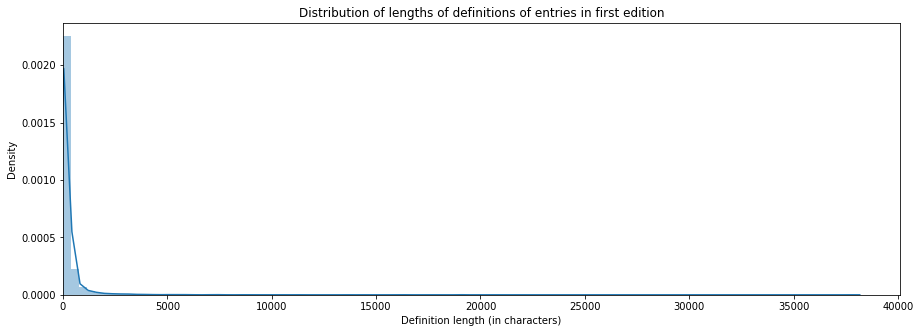

In [30]:
plt.figure(figsize=(15, 5))
chart = sns.distplot(first_ed_clean['def_length'], bins=100)
chart.set_title('Distribution of lengths of definitions of entries in first edition')
chart.set_xlabel("Definition length (in characters)")
chart.set_ylabel("Density")
plt.xlim(0)
plt.show()

From `describe()` we can see that the 75th percentile for `def_length` is 282, so I will regenerate the graph focusing on the smaller values to get a better look at the majority of the data.

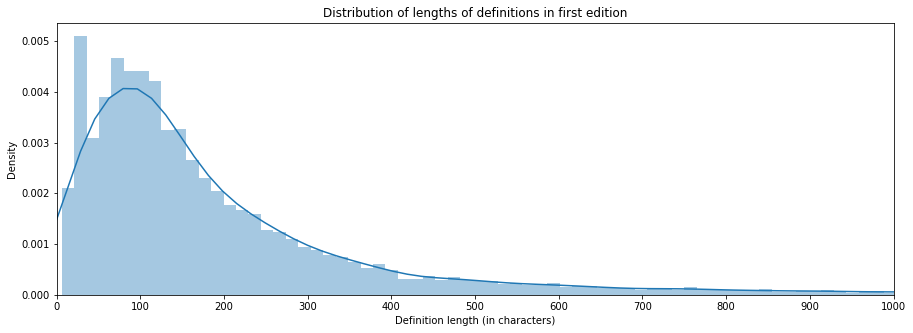

In [31]:
# 1000 chosen as most values seem to fall below it from the graph above
first_ed_short_descs = first_ed_clean.loc[first_ed_clean['def_length'] < 1500] 

plt.figure(figsize=(15, 5))
p = sns.distplot(first_ed_short_descs['def_length'], bins=100)
p.set_title('Distribution of lengths of definitions in first edition')
p.set_xlabel("Definition length (in characters)")
p.set_ylabel("Density")
p.set_xticks(np.arange(0,2000,100))
plt.xlim(0,1000)
plt.show()

We can see that the data takes the shape of a bell curve, with 75% of definitions falling below 282 characters, meaning that most definitions are relatively short.

We also notice a strange dip in the length of definitions at around 50 characters, which would need further investigation to explore. This might just be due to a lack of data, in which case we could check by visualising the lengths for all editions and seeing whether the dip gets smoothed out. Similar reasoning can be applied to the peak before this dip.

### Distribution of references to other entries in definitions

In [32]:
# find all references of the form of "See x" in definitions 

refs_in_desc = []

for index, row in first_ed_clean.iterrows():   
    refs_in_desc.append(len(re.findall('See [^,\.]*', row['definition']))) # matches "See x" until a comma or a period
    
first_ed_clean = first_ed_clean.assign(refs_in_desc=refs_in_desc)

first_ed_clean.describe()

,header_length,def_length,refs_in_desc
count,16012.000000,16012.000000,16012.000000
mean,7.662690,295.386835,0.259805
std,2.713464,821.197692,0.498402
min,3.000000,6.000000,0.000000
25%,6.000000,75.000000,0.000000
50%,7.000000,137.000000,0.000000
75%,9.000000,260.000000,0.000000
max,32.000000,37810.000000,6.000000


In [33]:
first_ed_clean

,headers,definition,header_length,def_length,refs_in_desc
34,UTILITY,ught to be the principal intention of every pu...,7,2268,0
38,AUTHORS,&c.\nviji\nHome on bl acking.\nJack’s conic fe...,7,1841,0
41,AABAM,"a term, among alchemifts, for lead,\n",5,36,0
42,AACH,the name of a town and river in Swabia. It is\...,4,93,0
43,AADE,"the name of two rivers, one in the country of\...",4,106,0
...,...,...,...,...,...
29871,WOOD COCK,"in ornithology. See Scolopax.\nWood louse, in ...",9,106,3
29872,WOT TON,"a market.town of Gloucefterfhire, fituated fe-...",7,82,0
29873,WYE\nWREATH,"in heraldry, a roll of fine linen or (ilk (lik...",10,222,0
29874,WRES FLING,a kind of combat or engagement between\ntwo pe...,10,178,1


In [34]:
# checking that it picks up what I want it to pick up correctly, through visual inspection

list(first_ed_clean.loc[first_ed_clean['refs_in_desc'] == 6].definition)[0] # should see 6 "See x"-type references

'in geometry, the ftraight line in a plain figure,\nabout which it revolves, to produce or generate a fo-\nlid : thus, if a femi-circle be moved round its diame\nter at reft, it will generate a fphere, the axis of which\nis that diameter.\nAxis, in aftronomy, is an imaginary right line fuppofed\nto pafs through the centre of the earth, and the hea\nvenly bodies, about which they perform their diurnal\nrevolutions.\nAxis in conic-fedtions, a right line dividing the fedtion\ninto two equal parts, and cutting all its ordinates at\nright angles. See Conic Sections.\nAxis, in mechanics. The axis of a balance is that line\nabout which it moves, or rather turns about. Axis\nof ofcillation is a right line parallel to the horizon,\npalling through the centre about which a pendulum\nvinrates. See Mechanics.\nAxis in peritrochio, one of the five mechanical potvers,\nconfifting of a peritrochium or wheel concentric with\nwith the bafe of a cylinder, and moveable together\nwith it about its axis. S

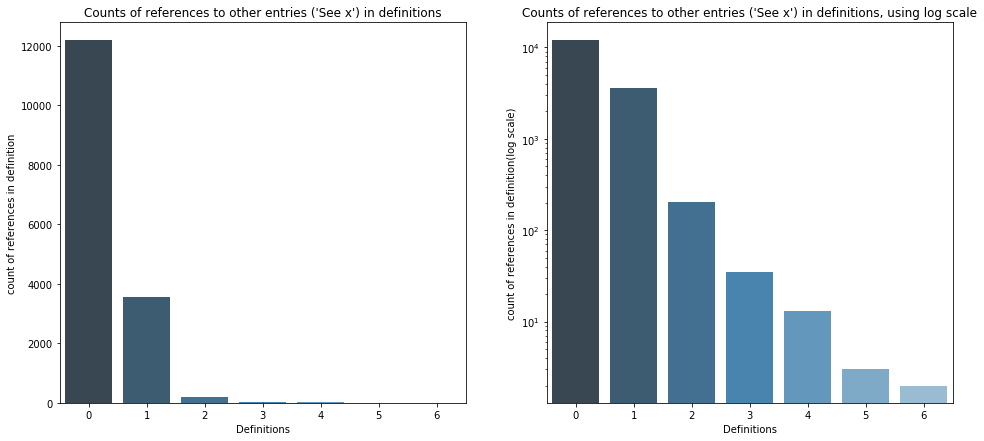

In [35]:
fig, ax = plt.subplots(1,2, figsize=(16, 7))
p = sns.countplot(x="refs_in_desc", data=first_ed_clean, ax=ax[0], palette="Blues_d")
p.set_xlabel('Definitions')
p.set_title("Counts of references to other entries ('See x') in definitions")
p2 = sns.countplot(x="refs_in_desc", data=first_ed_clean, ax=ax[1], palette="Blues_d")
p2.set_xlabel('Definitions')
p.set_ylabel("count of references in definition")
p2.set_title("Counts of references to other entries ('See x') in definitions, using log scale")
p2.set_yscale("log")
p2.set_ylabel("count of references in definition(log scale)")
# set y label

#plt.legend()
plt.show()

In this visualisation, we can see that most entries do not reference another entry in their definition. The second visualisation (using a log scale to better see the smaller values) shows that the values are an exponentially decreasing graph, meaning that a very small number of definitions will have very high numbers of references in them, and a very large number of them will have very few (or no) references. This gives us insight into how connected the entries in the encyclopaedia are, and can be useful for when comparing editions, to see if later editions are perhaps more connected.

### Most frequent words in first edition

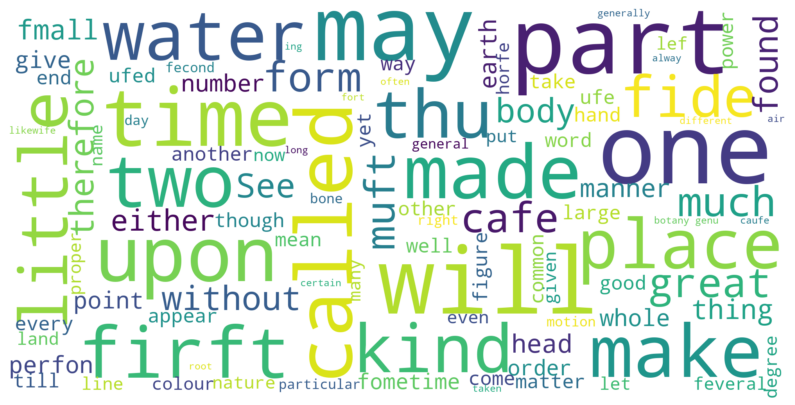

In [36]:
full_content = [] # text from all three volumes of the first edition

# adding most common misspelling of s as f to stopwords to be used in wordcloud
stopwords_s_to_f = []
for w in STOPWORDS:
    stopwords_s_to_f.append(re.sub("s", "f", w))
all_stopwords = STOPWORDS.union(stopwords_s_to_f)

stopwords = set(STOPWORDS) # to remove common stopwords

for index, row in first_ed.iterrows():

    #print("Reading: " + row['file'])
    f = open('text/' + row['file'], 'r', encoding="utf8")
    content = f.read()
    content = clean_up(content) 
    full_content.append(content)
    f.close()
    
full_content_str = ''.join(full_content)

wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white", scale=5, stopwords=all_stopwords).generate(full_content_str)
fig = plt.figure(1, figsize=(14, 14))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

We notice that some of the words in the wordcloud are not of much significance (such as verbs/adjectives/other connecting words), as well as misspellings, which reduces the usefulness of this visualisation.
We do notice interesting words, such as "place" (probably since the Encyclopaedia mentions various names of places), "body"/"head" (which makes sense, as in the next visualisation, we can see that Anatomy is a popular topic), "See" (due to the large number of references to other entries in the Encyclopaedia), "earth"/"water"/"land" (probably related to Agriculture, Botany, or Natural History, which are popular topics as based on the next visualisation), and "degree" (Geometry/Mechanics/Optics)

### Most referenced entries

In [37]:
# Converting unique counts to a DataFrame for easy visualisation

all_refs = pd.DataFrame(refs)
popular_refs = all_refs[0].value_counts()
df_popular_refs = pd.DataFrame(popular_refs[:20]) # selecting just the top 20
df_popular_refs['references'] = df_popular_refs.index
df_popular_refs.columns = ['count', 'references']
df_popular_refs = df_popular_refs.reset_index(drop=True)
df_popular_refs.head()

,count,references
0,321,See Anatomy
1,151,See Law
2,131,See Medicine
3,119,See Chemistry
4,112,See Astronomy


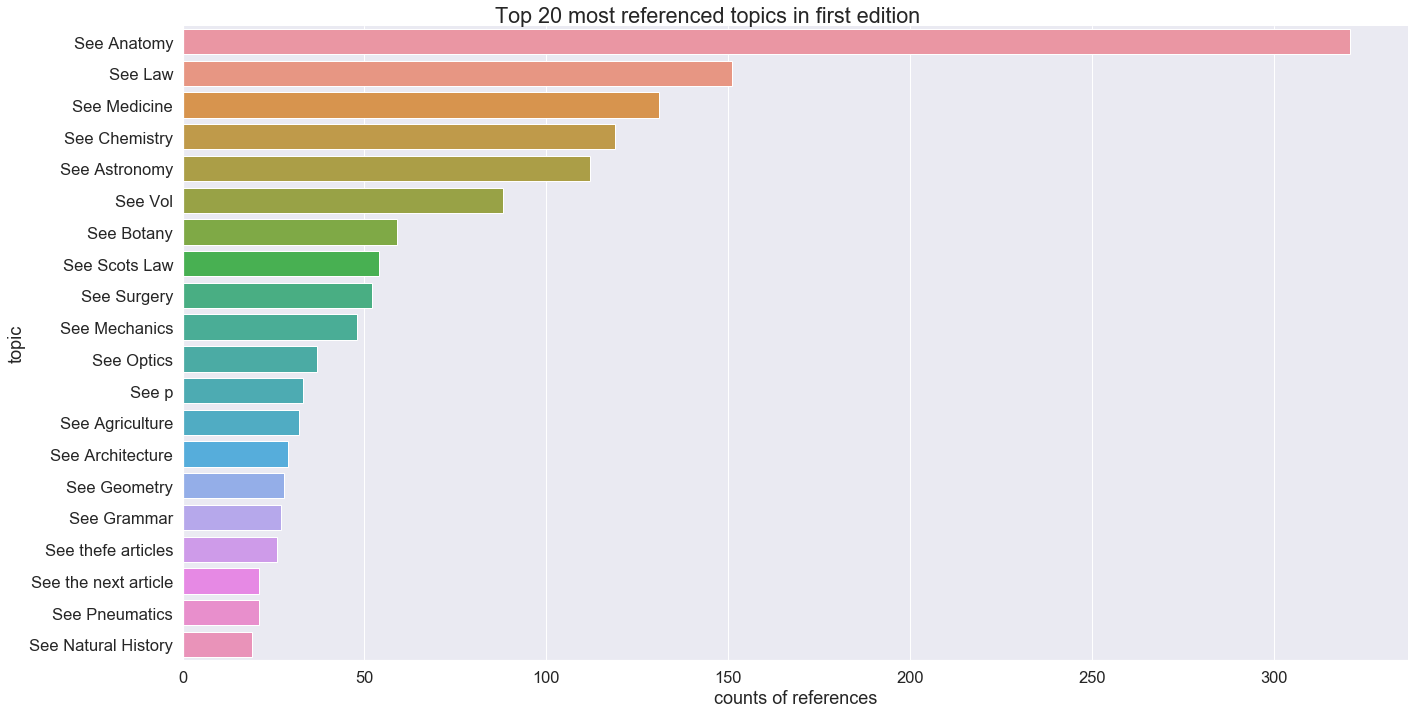

In [38]:
sns.set(font_scale=1.5)
ax = sns.catplot(x='count', y='references', data=df_popular_refs, kind='bar', height=10, aspect=2)
ax.fig.suptitle("Top 20 most referenced topics in first edition", y=1)
ax.set_axis_labels('counts of references', 'topic')

From this visualisation, we can see which topics are referenced the most in the first edition, which can be used to infer what topics were important, due to the number of entries mentioning them. The results are expected, with general topics such as Anatomy, Law, Medicine, Chemistry. However, some topics are more niche, such as pneumatics and optics, thus we can assume those fields were popular or researched at the time.

We do also see some entries not being topics, but instead, referencing parts of the Encyclopaedia itself ("See Vol", "See p.", "See thefe articles", "See the next article").

Another interesting aspect is that both Law and Scots law appear as separate topics, which matches the fact that the Encyclopaedia was compiled in Scotland.

## Reflection

We have learned that the definitions of entries in an Encyclopaedia are usually rather succinct (a few hundred characters). This would make sense as an Encyclopaedia is meant to be a summary of knowledge and easily browseable, but a few entries might require deeper explanation, thus the distribution takes the shape of a bell curve.

We also notice that most entries do not reference other entries with a "See x", which indicates that most entries were deemed not linked closely enough to a topic to warrant a reference, which gives us insight into how knowledge is organised and connected in this specific Encyclopaedia, as well as the nature of the content: a lot of entries are referencing objects or places, which are not related to a specific topic.

We can also see that a lot of references are to "See Vol", "See p" and "See next article", which indicates that the Encyclopaedia is interconnected in different ways: through references to specific entries, as well as references to pages and volumes, which might be either references to figures, or broader references to longer-form articles.

We also learn more about the content in this first edition through the most common words and referenced topics, which indicate which fields were considered important and had been researched more deeply than others at the time.

### Hypotheses:
#### The topics that are most referenced in an edition reflect what fields were being explored at the time.
In the "Most referenced entries" visualisation, we mostly see broad topics such as "Agriculture", "Chemistry", "Medicine", but also more niche topics such as "Pneumatics" and "Optics". It is probable that that these more specific topics are prominent because those fields were being studied more intensely and more discoveries were being made about them during the time of the writing of this edition of the Encylopaedia.

I would test this by visualising the data for all editions, to check whether there are any changes in popularity of references to topics across time, and confirm this by researching the history of those fields around the time of the publications.

#### The Encyclopaedia is not an unbiased account of knowledge.
The words "good" and "great" both appear in the "Most frequent words in first edition" wordcloud: it would be valuable to investigate in what context they appear, and use sentiment analysis across the editions to investigate whether the editions have gotten more or less biased, what topics are the more/less biased, as well as which topics underwent the largest changes in bias.

#### There is a correlation between most popular words & most referenced topics
As mentioned in the description of the "Most frequent words in first edition" wordcloud, there seems to be a link between some of the most commonly mentioned words ("body", "head", "earth", "water"), and the most referenced topics from the final visualisation ("Anatomy", "Agriculture", "Botany", "Natural History"). It would be interesting to explore whether the change in popularity in topics influences the popularity of the most commonly referenced words that are related to a topic quite closely, making this a strong relationship between the two variables, or not.


#### Knowledge becomes more interlinked with each new edition.

In the "Distribution of references to other entries in definitions" visualisation, we can see that most entries in the first edition do not reference other entries, while those that do mostly reference one other topic. It would be valuable to visualise this data for all editions, to see whether the proportion changes: I would like to hypothesise that as time goes by, more knowledge is linked to existing topics and entries, rather than the addition of entirely new, unrelated concepts.